# Streaming TimeSeries prediction using SPSS Flow deployed in WML

**(C) 2020 IBM - Philippe Gregoire - Ecosystem Advocacy Group Europe - Partners Technical Enablement**

## Prerequisites:
* A SPSS Flow with a Streaming Time Series node must be deployed to Watson Machine Learning
* An input file in CSV format with columns matching the deployed WML SPSS model must be present in Cloud Object Storage

## Operations
* We first load the CSV file from COS into a pandas DataFrame, `df_data`
* That dataframe is converted to an array of rows, each row itself being an array or individual values.
* We initialize the WML client with the WML credentials where that model is deployed.
* The array of timeseries values is fed into a WML prediction call
* The predictions are returned in JSON-formatted text
* We convert the text to JSON (Python dictionary) and then back to a Results DataFrame
* The predictions DataFrame is then stored in a new file in COS

## Notes
* Here we assume that the input CSV file has been created in COS from its DB2 data source tables, using a Data refinery flow that has joined the two
* We could also connect directly to the DB2 tables and build the dataframe from there rather than going through COS

## insert input data asset credentials
* Place our cursor in the code cell below, remove the existing code.
* Use the 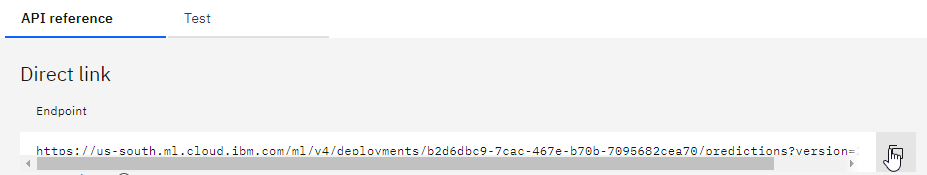menu at the top right, to open the data pane, then locate the `broadband.csv` file and select *Insert to code->Crednetials* 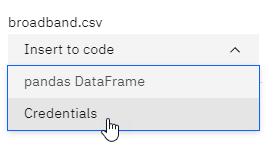
* rename `credentials_x` variable to `cos_credentials`

In [1]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
cos_credentials = {
    'IAM_SERVICE_ID': ENTERYOUROWNCREDENTIALS,
    'IBM_API_KEY_ID': ,
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'streamingtslab-donotdelete-pr-eiarcmwm96atvm',
    'FILE': 'broadband.csv'
}

## Enter IAM token
In a separate tab, navigate to https://cloud.ibm.com/iam/apikeys, then click 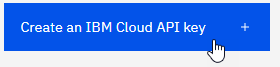, give it a name, e.g. `Market_APIKey`, copy to clipboard 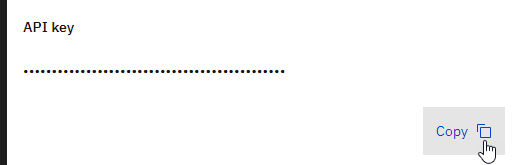 and paste the value in the cell below, surrounded by quotes

In [2]:
IAM_APIKEY=Enter Your OWn KEy HERE!

## Set WML location
We assume your WML service runs within `us-south` region, if not change it below (`eu-gb`, `eu-de`)

In [3]:
wml_location='us-south'

In [4]:
# Setup some constants
# Name of the timestamp field/column
key_ts='DATE_'
# Number of Markets
MarketMax=85
# Name of WML model
TSModelName='Online_Market_Predict'

In [5]:
# Get the data from the joined COS table object, using the credentials from above
import types
import numpy as np
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=cos_credentials['IBM_API_KEY_ID'],
    ibm_auth_endpoint=cos_credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=cos_credentials['ENDPOINT'])

body = cos.get_object(Bucket=cos_credentials['BUCKET'],Key=cos_credentials['FILE'])['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Read the input Time Series file
df_ts = pd.read_csv(body)

In [6]:
# Adjust types, so that we can sort on timestamp
df_ts[key_ts]=pd.to_datetime(df_ts[key_ts])
# show some statistics
df_ts.dtypes.to_frame().transpose().append(df_ts.describe())

,Market_1,Market_2,Market_3,Market_4,Market_5,Market_6,Market_7,Market_8,Market_9,Market_10,...,Market_80,Market_81,Market_82,Market_83,Market_84,Market_85,Total,YEAR_,MONTH_,DATE_
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,int64,int64,datetime64[ns]
count,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,NaN
mean,7786.09,32486.1,38800.6,10250.7,4358.85,12926.1,14404.7,4974.89,11969.6,15685.8,...,5959.19,25656.9,44841.9,15899.3,11397.2,13960.7,1.38232e+06,2001,6.5,NaN
std,2437.92,13223.9,17239,4004.08,1229.75,5266.5,5188.52,1646.25,5293.94,4736.92,...,1817.5,8644.93,18836.3,6822.99,3629.06,4605.25,554993,1.42615,3.48118,NaN
min,3750.18,11488.6,11658.8,4571.34,2205.46,5487.83,6143.92,2363.48,5041.96,6723.89,...,3042.21,9860.9,14480.6,7000.21,5648.5,6818.4,536413,1999,1,NaN
25%,6089.71,21077.1,21887.2,6792.08,3365.16,8173.65,9868.5,3703.59,7661.67,11845.5,...,4542.68,19137.2,28605.7,10176.3,8336.38,9797.82,900182,2000,3.75,NaN
50%,7491.76,32336.5,39783.7,9257.31,4330.71,12847.4,13535.8,4713.32,10425.2,15984.2,...,5962.48,25920.3,44752.2,14251.9,11443.9,14395,1.34187e+06,2001,6.5,NaN
75%,10180.6,44575.5,55381.7,13253.3,5404.68,16951.4,19595.6,6450.07,16282.5,20011.3,...,7340.76,32633.5,60419.2,21381.9,14327.4,17284.3,1.83374e+06,2002,9.25,NaN
max,11731.1,53703.8,60754.9,17977.2,6610.84,22788.8,22294.1,7623.25,22930.9,23030,...,9380.13,41935.8,76629.6,29810.6,16797.9,23017.7,2.40676e+06,2003,12,NaN


In [7]:
# Order by timestamp
df_ts.sort_values(key_ts,inplace=True)
# Show the data
df_ts

,Market_1,Market_2,Market_3,Market_4,Market_5,Market_6,Market_7,Market_8,Market_9,Market_10,...,Market_80,Market_81,Market_82,Market_83,Market_84,Market_85,Total,YEAR_,MONTH_,DATE_
0,3750.179792,11488.581108,11658.795443,4571.338134,2205.463753,5487.834374,6143.918612,2363.483431,5041.957905,6723.886292,...,3042.208010,9860.896324,14480.626177,7000.206110,5648.500592,6818.398467,5.364128e+05,1999,1,1999-01-01
1,3846.066274,11984.018649,12227.942408,4824.890057,2301.426550,5671.674406,6389.757679,2404.099038,5159.707716,6970.350934,...,3069.078520,10431.792233,15162.226892,7271.916925,5750.185462,6943.441941,5.587971e+05,1999,2,1999-02-01
2,3894.418165,12265.668765,12896.507548,5040.973564,2352.200626,5802.188406,6669.757684,2468.803621,5232.018706,7338.078740,...,3138.725721,11141.036381,15961.208551,7667.776557,5900.555299,7129.984845,5.820775e+05,1999,3,1999-03-01
3,4009.801974,12800.948326,13715.694537,5210.632898,2489.513496,5899.444825,6929.257517,2573.599758,5403.422185,7741.644982,...,3218.465458,11839.783548,16932.897439,7868.932197,5943.681184,7332.548143,6.053324e+05,1999,4,1999-04-01
4,4146.703036,13290.949737,14646.745863,5383.489476,2534.314453,6016.973845,7312.021798,2654.271723,5543.335502,8146.843838,...,3329.932008,12595.677343,17758.368463,8057.187104,6008.612768,7637.344367,6.300192e+05,1999,5,1999-05-01
5,4334.559128,13828.143236,15419.372989,5495.729505,2663.904815,6137.370951,7492.860913,2698.560955,5773.466675,8376.618298,...,3431.114773,13464.406432,18266.475345,8427.571264,6176.535718,7929.931449,6.546938e+05,1999,6,1999-06-01
6,4554.119797,14273.262263,16107.797469,5746.520152,2737.940684,6249.770282,7701.632070,2786.208837,5904.352691,8733.319731,...,3504.791522,14260.210383,19058.463338,8587.055702,6313.399124,8144.915569,6.788767e+05,1999,7,1999-07-01
7,4744.258115,14664.356020,16958.175520,5884.548170,2753.582676,6439.344135,7965.437231,2847.155456,6032.433559,9089.511914,...,3685.707930,15270.571189,19881.377224,8822.608984,6429.562671,8270.018476,7.029581e+05,1999,8,1999-08-01
8,4884.630434,15130.442301,17642.076841,6053.445148,2874.400661,6701.417052,8107.397173,2966.768579,6149.657530,9534.434302,...,3785.846034,15991.183156,20995.830479,8922.224202,6718.495006,8362.664453,7.276665e+05,1999,9,1999-09-01
9,5019.520503,15851.402308,18452.871680,6229.124375,2974.863483,6957.021864,8366.188266,3098.756745,6342.630957,9999.307534,...,3879.054256,16821.871443,21851.287163,9178.170578,6908.245424,8595.508647,7.524670e+05,1999,10,1999-10-01


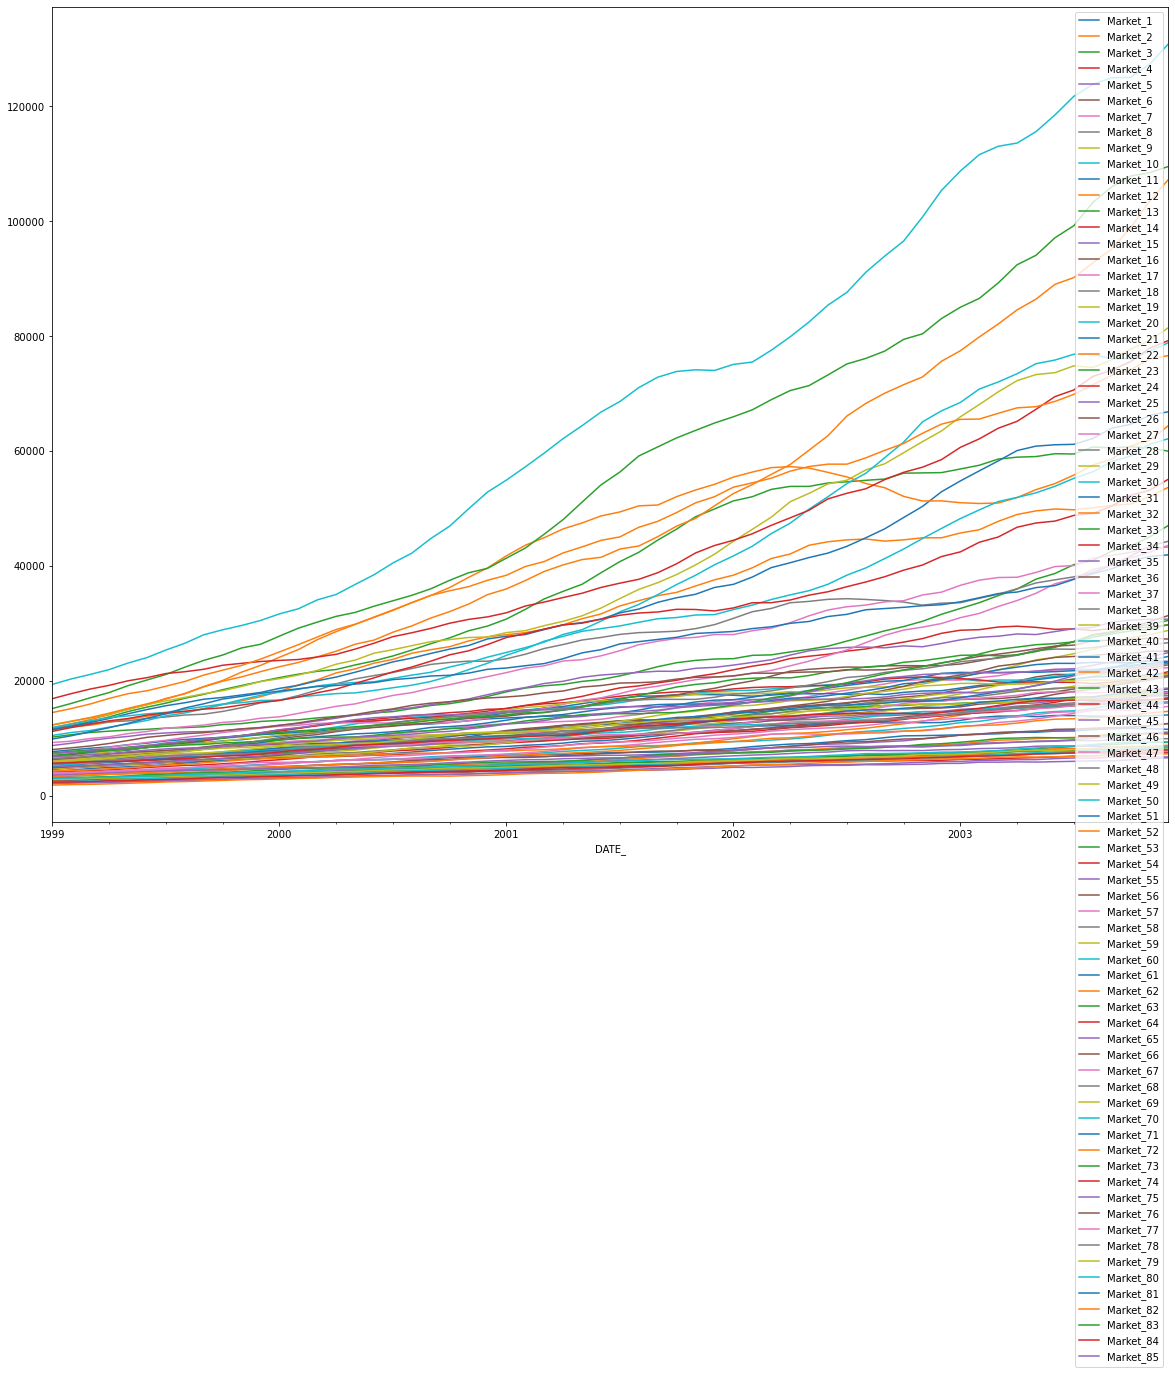

In [8]:
# plot Market_1 to market_5 after setting index to the DATE_ column
df_ts.set_index(key_ts)[['Market_{}'.format(x+1) for x in range(0,MarketMax)]].plot(figsize=(20,15));

In [9]:
# Locate the WML model
# Load WML Client API
from ibm_watson_machine_learning import APIClient

wmlClient = APIClient({ "apikey": IAM_APIKEY,
                        "url": f"https://{wml_location}.ml.cloud.ibm.com" })
wmlClient.spaces.list(limit=10)
print('Select a space ID from the above list and paste it in the space_id= below')

------------------------------------  ----------------  ------------------------
ID                                    NAME              CREATED
8e2de68b-dc4d-4234-bea8-79bbe5af8f66  Market_DeplSpace  2020-11-18T18:30:33.854Z
------------------------------------  ----------------  ------------------------
Select a space ID from the above list and paste it in the space_id= below


In [10]:
space_id='8e2de68b-dc4d-4234-bea8-79bbe5af8f66'

In [11]:
# Find our model deployment
wmlClient.set.default_space(space_id)
deplRes=wmlClient.deployments.get_details()['resources']
depls=[d for d in deplRes if d['entity']['name']==TSModelName]
if len(depls)>0:
    depl=depls[0]
    depl_uid=wmlClient.deployments.get_uid(depl)
    depl_ent=depl['entity']
    print(f"Got deployment for model {TSModelName}")
else:
    print(f"Deployment with name {TSModelName} not found. Existing deployments: {[x['entity']['name'] for x in deplRes]}")

Got deployment for model Online_Market_Predict


## Score with the WML Python API
The Python API has the convenience of allowing scoring input to be a dataframe, we will first show this below

In [12]:
# Get the model details
model_ent=wmlClient.repository.get_model_details(depl_ent['asset']['id'])['entity']
# Create a data frame structure that matches the model's 'input_data_schema'
input_columns=[x['name'] for x in model_ent['schemas']['input'][0]['fields']]
# Keep only the columns that are part of the model schema
df_ts=df_ts[input_columns]
# Convert date back to string to make it JSON serializable
df_ts[key_ts]=df_ts[key_ts].astype(str)
df_ts.head(2)

,Market_1,Market_2,Market_3,Market_4,Market_5,Market_6,Market_7,Market_8,Market_9,Market_10,...,Market_80,Market_81,Market_82,Market_83,Market_84,Market_85,Total,YEAR_,MONTH_,DATE_
0,3750.179792,11488.581108,11658.795443,4571.338134,2205.463753,5487.834374,6143.918612,2363.483431,5041.957905,6723.886292,...,3042.20801,9860.896324,14480.626177,7000.206110,5648.500592,6818.398467,536412.830264,1999,1,1999-01-01
1,3846.066274,11984.018649,12227.942408,4824.890057,2301.426550,5671.674406,6389.757679,2404.099038,5159.707716,6970.350934,...,3069.07852,10431.792233,15162.226892,7271.916925,5750.185462,6943.441941,558797.075192,1999,2,1999-02-01


In [13]:
# Score using the WML API directly on the dataframe
print(f"predicting with {df_ts.shape[0]} lines as input")
predictions = wmlClient.deployments.score(depl_uid, {"input_data":[{"values":df_ts}]})

predicting with 60 lines as input


In [14]:
# Convert response back to dataframe
pred0=predictions['predictions'][0]
dfPredict=pd.DataFrame.from_records(pred0['values'],columns=pred0['fields'])
# Convert TS column
dfPredict[key_ts]=pd.to_datetime(dfPredict[key_ts],format="%Y-%m-%d %H:%M %p %Z")
dfPredict

,DATE_,$FutureFlag,Market_1,Market_2,Market_3,Market_4,Market_5,$TS-Market_1,$TSLCI-Market_1,$TSUCI-Market_1,...,$TSUCI-Market_3,$TSResidual-Market_3,$TS-Market_4,$TSLCI-Market_4,$TSUCI-Market_4,$TSResidual-Market_4,$TS-Market_5,$TSLCI-Market_5,$TSUCI-Market_5,$TSResidual-Market_5
0,1999-01-01 00:00:00+00:00,0,3750.179792,11488.581108,11658.795443,4571.338134,2205.463753,NaN,NaN,NaN,...,12419.530032,32.156282,4890.455333,4063.503596,5837.728701,-0.063388,NaN,NaN,NaN,NaN
1,1999-02-01 00:00:00+00:00,0,3846.066274,11984.018649,12227.942408,4824.890057,2301.426550,NaN,NaN,NaN,...,13094.484519,-73.651240,4698.140625,4537.952946,4862.535775,0.026770,NaN,NaN,NaN,NaN
2,1999-03-01 00:00:00+00:00,0,3894.418165,12265.668765,12896.507548,5040.973564,2352.200626,NaN,NaN,NaN,...,13638.305011,51.093408,4892.443367,4725.635377,5063.632592,0.030056,2419.062014,2299.504685,2543.232409,-0.027713
3,1999-04-01 00:00:00+00:00,0,4009.801974,12800.948326,13715.694537,5210.632898,2489.513496,NaN,NaN,NaN,...,14316.428311,192.157096,5198.674335,5021.430421,5380.573449,0.002446,2417.864126,2309.770972,2529.716066,0.029460
4,1999-05-01 00:00:00+00:00,0,4146.703036,13290.949737,14646.745863,5383.489476,2534.314453,4223.066397,3880.202871,4588.216910,...,15222.755311,216.881423,5397.799656,5213.772090,5586.660446,-0.002506,2511.843303,2402.423010,2624.967834,0.009150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2004-01-01 00:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,11547.287173,11270.652722,11828.994425,...,60469.967927,NaN,17851.253431,17300.037866,18415.548334,NaN,6490.469705,6263.981250,6723.058998,NaN
61,2004-02-01 00:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,11670.080323,11284.369129,12065.618156,...,60663.681623,NaN,17703.302567,16937.028971,18495.309424,NaN,6266.476725,6015.377706,6525.373730,NaN
62,2004-03-01 00:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,11742.555239,11278.244558,12221.088945,...,60991.402799,NaN,17597.338170,16671.590733,18561.146755,NaN,6400.322872,6143.860610,6664.749677,NaN
63,2004-04-01 00:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,11857.482483,11328.201134,12405.139385,...,61424.409101,NaN,17572.888652,16512.910287,18683.139411,NaN,6523.684584,6262.279192,6793.208029,NaN


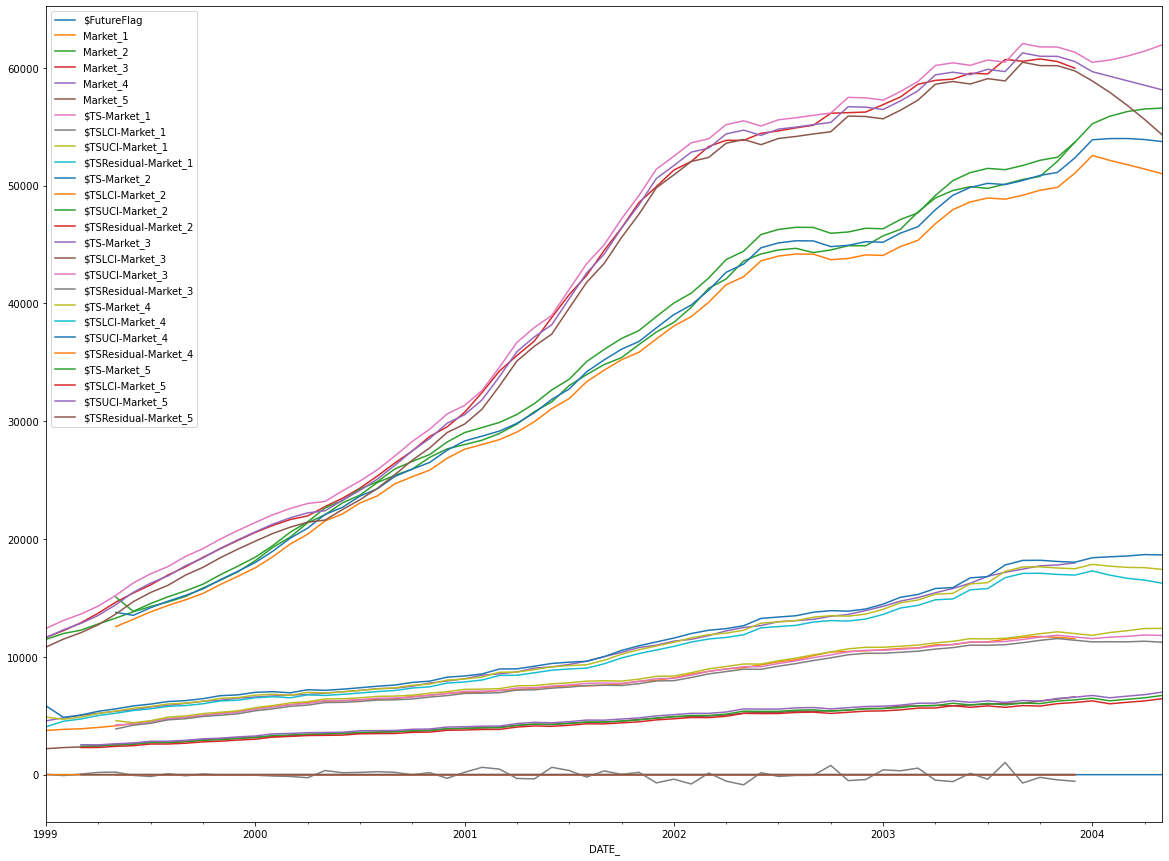

In [15]:
# Plot
dfPredict.set_index(key_ts).plot(figsize=(20,15));

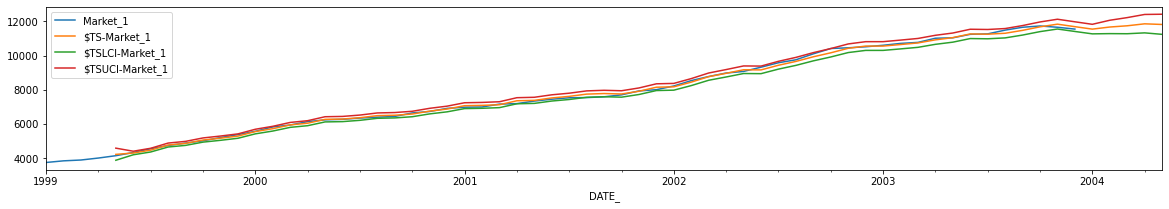

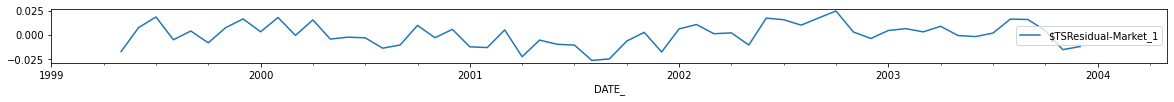

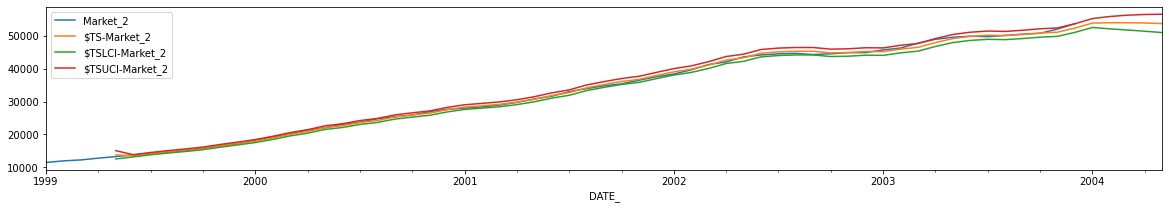

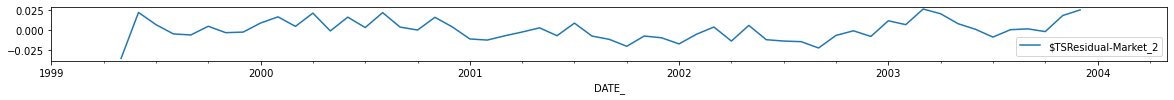

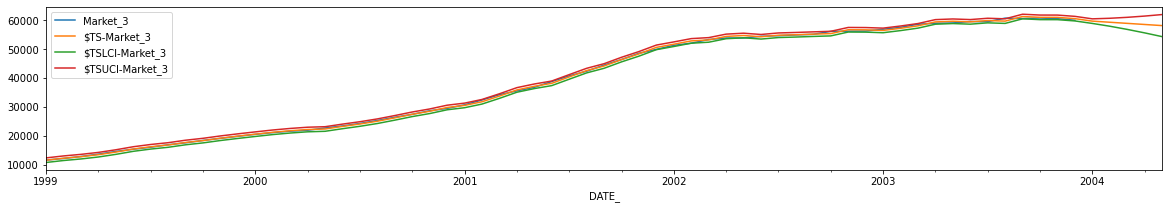

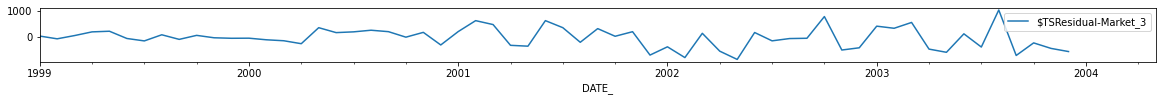

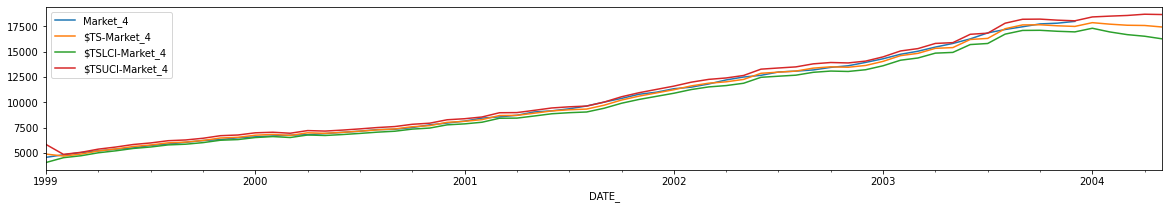

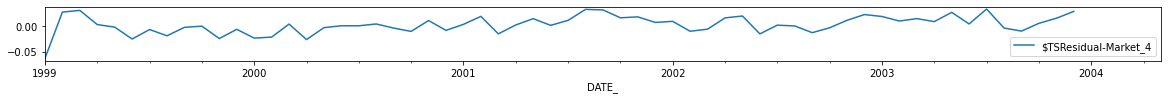

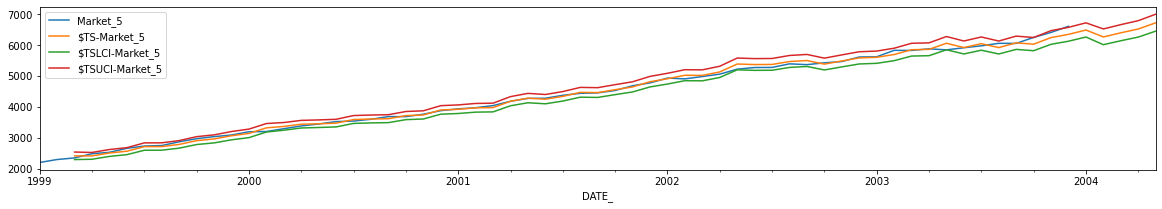

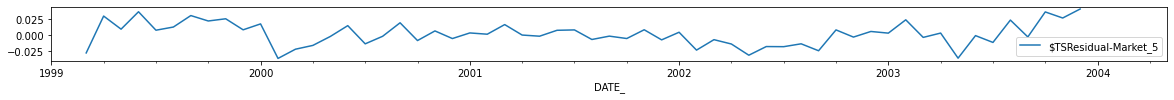

In [16]:
# plot each market
marketNum=4
for marketNum in range(1,6):
    marketCols=[key_ts]
    [marketCols.append(x) for x in dfPredict.columns if x.endswith('Market_{}'.format(marketNum)) and x.find("Residual")==-1]
    dfPredict[marketCols].set_index(key_ts).plot(figsize=(20,3));
    dfPredict[[key_ts,'$TSResidual-Market_{}'.format(marketNum)]].set_index(key_ts).plot(figsize=(20,1));

In [17]:
# Write out the CSV data to a file object in COS
import io
cos.upload_fileobj(io.BytesIO(dfPredict.to_csv(encoding='utf-8').encode('utf-8')),cos_credentials['BUCKET'],"predicted_{}".format(cos_credentials['FILE']))

## Scoring with REST endpoint
WML models prediction endpoints are exposed as a REST service, so it can also be invoked through standard `requests` library.     
We will get a token for our API Key   
Here we get the WML endpoint URL from the deploymet UID, but you can also get it from the Deployment Space's UI at e.g. https://dataplatform.cloud.ibm.com/ml-runtime/spaces

In [18]:
import requests

wml_endpoint=depl_ent['status']['online_url']['url']+'?version=2020-11-18'
print(wml_endpoint)
#wml_endpoint="https://us-south.ml.cloud.ibm.com/ml/v4/deployments/b2d6dbc9-7cac-467e-b70b-7095682cea70/predictions?version=2020-11-18"
#print(wml_endpoint)

# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
token_response = requests.post('https://iam.ng.bluemix.net/identity/token', data={"apikey": IAM_APIKEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"fields": [c for c in df_ts.columns], "values": [[str(val) for val in row] for row in df_ts.itertuples(index=False,name=None)]}

response_scoring = requests.post(wml_endpoint, json={'input_data':[payload_scoring]}, headers={'Authorization': 'Bearer ' + mltoken})

https://us-south.ml.cloud.ibm.com/ml/v4/deployments/b2d6dbc9-7cac-467e-b70b-7095682cea70/predictions?version=2020-11-18


In [19]:
if response_scoring.ok:
    predictions=response_scoring.json()["predictions"][0]
    print(f"Got predictions: {predictions}")
else:
    print(f"Scoring response: {response_scoring} {response_scoring.text}")

Got predictions: {'fields': ['DATE_', '$FutureFlag', 'Market_1', 'Market_2', 'Market_3', 'Market_4', 'Market_5', '$TS-Market_1', '$TSLCI-Market_1', '$TSUCI-Market_1', '$TSResidual-Market_1', '$TS-Market_2', '$TSLCI-Market_2', '$TSUCI-Market_2', '$TSResidual-Market_2', '$TS-Market_3', '$TSLCI-Market_3', '$TSUCI-Market_3', '$TSResidual-Market_3', '$TS-Market_4', '$TSLCI-Market_4', '$TSUCI-Market_4', '$TSResidual-Market_4', '$TS-Market_5', '$TSLCI-Market_5', '$TSUCI-Market_5', '$TSResidual-Market_5'], 'values': [['1999-01-01 00:00 AM UTC', 0, 3750.1797916378027, 11488.581108444763, 11658.795442908433, 4571.3381344420395, 2205.4637525068697, None, None, None, None, None, None, None, None, 11626.63916091477, 10833.748290035779, 12419.530031793762, 32.15628199366256, 4890.455332518289, 4063.5035960759556, 5837.72870095512, -0.06338770769318458, None, None, None, None], ['1999-02-01 00:00 AM UTC', 0, 3846.066273602286, 11984.018648938852, 12227.942408314311, 4824.890057313729, 2301.4265504988